In [1]:
%load_ext autoreload
%autoreload 2
import HammingCode
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import erfc
import NeuralNetworkCorrection as network
import Autoencoder
import tensorflow as tf

2024-06-07 14:36:59.134661: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-07 14:36:59.134755: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-07 14:36:59.136426: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-07 14:36:59.147879: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-07 14:37:00.435111: W tensorflow/compiler/tf2

In [2]:
variancia = 1
code_rate = 4/7
# amostra
Eb_dB_values = np.arange(-5, 12, 1)

# Gerar dados de treinamento
training_sample_length = 10 ** 5
epoches = 15
batch_size = 64

In [3]:
training_data = {
    'original': [],
    'noisy': [],
    'info': []
}

training_information = network.get_training_data_set(training_sample_length)

for eb_db in Eb_dB_values:
    info = network.generate_data_for_training(training_information, eb_db, variancia)
    training_data['noisy'].extend(info['split_noisy_original_data_15_11'])
    training_data['original'].extend(info['split_original_data_15_11'])

training_data['noisy'] = np.array(training_data['noisy'])
training_data['original'] = np.array(training_data['original'])

In [4]:
# Criar e treinar a rede neural
model = network.train_neural_network(training_data, epoches, batch_size)

Epoch 1/15
2174/2174 [==============================] - 15s 6ms/step - loss: 0.2868 - accuracy: 0.1850 - val_loss: 0.2812 - val_accuracy: 0.0673 - lr: 0.0010
Epoch 2/15
2174/2174 [==============================] - 13s 6ms/step - loss: 0.2809 - accuracy: 0.1797 - val_loss: 0.2781 - val_accuracy: 0.1344 - lr: 0.0010
Epoch 3/15
2174/2174 [==============================] - 13s 6ms/step - loss: 0.2800 - accuracy: 0.1874 - val_loss: 0.2805 - val_accuracy: 0.0985 - lr: 0.0010
Epoch 4/15
2174/2174 [==============================] - 14s 6ms/step - loss: 0.2793 - accuracy: 0.1876 - val_loss: 0.2785 - val_accuracy: 0.1788 - lr: 0.0010
Epoch 5/15
2174/2174 [==============================] - 13s 6ms/step - loss: 0.2786 - accuracy: 0.1865 - val_loss: 0.2786 - val_accuracy: 0.2665 - lr: 0.0010
Epoch 6/15
2174/2174 [==============================] - 13s 6ms/step - loss: 0.2781 - accuracy: 0.1885 - val_loss: 0.2782 - val_accuracy: 0.1901 - lr: 0.0010
Epoch 7/15
2174/2174 [==============================

In [5]:
# = Autoencoder.create_and_train_auto_encoder(training_data, epoches, batch_size)

In [6]:
#autoencoder.save('autoencoder')
model.save('mlp')



INFO:tensorflow:Assets written to: mlp/assets


INFO:tensorflow:Assets written to: mlp/assets


In [7]:
autoencoder = tf.keras.models.load_model('autoencoder')
model = tf.keras.models.load_model('mlp')

In [8]:
# Gerar dados de teste
amostras_ruidosas = []
amostras_originais = []
ML_result = []
tradicional_result = []
autoencoder_result = []


In [9]:
test_data = {
    'original': [],
    'info': []
}
test_sample_length = 10 ** 5
test_information = network.get_training_data_set(test_sample_length)

BER_tradicional = []
BER_autoencoder = []
BER_ML = []

padded_array = []
for eb_db in Eb_dB_values:
    info = network.generate_data_for_training(test_information, eb_db, variancia)
    test_data['original'] = info['original_data']
    
    #autoencoder_result = (network.decode_and_correct(info['split_noisy_original_data_15_11'], autoencoder))
    ML_result = (network.decode_and_correct(info['split_noisy_original_data_15_11'], model))
    tradicional_result = (HammingCode.decode_sample(info['split_encoded_data']))
    padded_array = info['padded_array_original_data']
    
    BER_ML.append(np.sum(np.array(ML_result).astype(int) != padded_array) / len(padded_array))
    BER_tradicional.append(np.sum(np.array(tradicional_result).astype(int) != test_data['original']) / len(test_data['original']))
    #BER_autoencoder.append(np.sum(np.array(autoencoder_result).astype(int) != padded_array) / len(padded_array))
    print(eb_db)

-5
-4
-3
-2
-1
0
1
2
3
4
5
6
7
8
9
10
11


In [10]:
    

# Calcular a BER teórica
Eb_coded = np.array([eb_db + 10*np.log10(code_rate) for eb_db in Eb_dB_values])
Eb_values = 10**(Eb_coded/10)
BER_teorica_codificado = 0.5 * erfc(np.sqrt(Eb_values))

Eb_values_BPSK = 10**(Eb_dB_values/10)
BPSK = 0.5 * erfc(np.sqrt(Eb_values_BPSK))

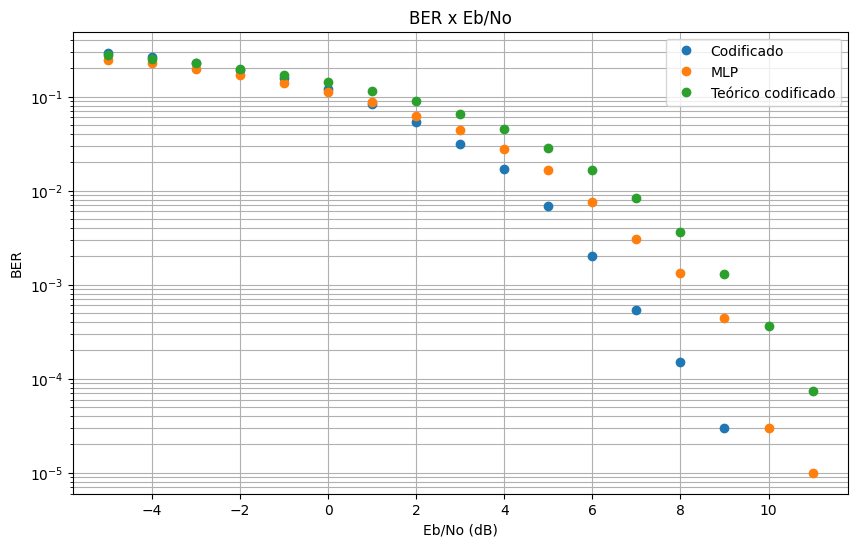

In [11]:
# Plotar as taxas de erro de bit simuladas e teóricas
plt.figure(figsize=(10, 6))
plt.semilogy(Eb_dB_values, BER_tradicional, marker='o', linestyle='', label='Codificado')
#plt.semilogy(Eb_dB_values, BER_autoencoder, marker='o',  linestyle='',label='Autoencoder')
plt.semilogy(Eb_dB_values, BER_ML, marker='o', linestyle='', label='MLP')
#plt.semilogy(Eb_dB_values, BPSK, marker='o', linestyle='', label='BPSK')
plt.semilogy(Eb_dB_values, BER_teorica_codificado, marker='o', linestyle='', label='Teórico codificado')

plt.xlabel('Eb/No (dB)')
plt.ylabel('BER')
plt.grid(True, which='both')
plt.legend()
plt.title('BER x Eb/No')
plt.show()